# Model Quality Metrics

## Overview
This notebook demonstrates advanced evaluation metrics for US cities demographic analysis using LLM-as-a-Judge methodology.

## What We'll Cover
1. **Programmatic Testing** - Verify model accuracy against ground truth city data
2. **LLM as a Judge** - Assess response quality, accuracy, and analytical depth
3. **Evaluation Analysis** - Compare performance across question types and complexity levels
4. **Results Visualization** - Present findings and recommendations

## Prerequisites
- AWS account with Bedrock access
- Python 3.10+
- boto3 library

## Setup and Dependencies

In [1]:
import pandas as pd
import json
from time import sleep

# Import our modular utility functions
from utils import *

# Configuration Parameters
DATA_PATH = "./city_pop.csv"
SHOW_DETAILED_RESULTS = True 
SCALE_TEST_SAMPLES = 1000  # Number of samples for scale testing
RANDOM_SEED = 42  # For reproducibility
SHOW_PLOTS = True  # Display visualization


print("Utility modules loaded")


Utility modules loaded


## 1. Load the dataset 

We will be using the US Cities Population Dataset which contains comprehensive demographic and geographic information for the top 314 most populous cities in the United States. This dataset provides a detailed snapshot of American urban demographics, featuring cities with populations ranging from over 8.4 million (New York City) down to approximately 100,000 residents (Sunrise, FL).

**Dataset features:**
- **city**: Name of the city
- **state**: Two-letter state abbreviation 
- **population**: Current population count (formatted with commas as strings)
- **land_area_mi2**: Land area in square miles

**Dataset characteristics:**
- **Size**: 314 cities across all 50 US states plus Washington DC
- **Population range**: 8,478,072 (New York) to 100,128 (Sunrise, FL)
- **Geographic coverage**: Represents major metropolitan areas nationwide
- **Data quality**: Some entries contain footnote references that may need cleaning

This comprehensive dataset is ideal for analyzing urban demographics, population density patterns, regional growth trends, and the geographic distribution of America's largest cities. The inclusion of both population and land area data enables calculations of population density and comparative urban planning analysis.





In [27]:

df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded: {df.shape[0]} cities, {df.shape[1]} features")
print(f"Features available: {list(df.columns)}")

# Display sample data for context
print("\n Sample city records:")
for i in range(min(3, len(df))):
    print(f"\n--- City {i+1} ---")
    print(f"City: {df.iloc[i]['city']}")
    print(f"State: {df.iloc[i]['state']}")
    print(f"Population: {df.iloc[i]['population']}")
    print(f"Land Area: {df.iloc[i]['land_area_mi2']} sq mi")


Dataset loaded: 346 cities, 4 features
Features available: ['city', 'state', 'population', 'land_area_mi2']

 Sample city records:

--- City 1 ---
City: New York[c]
State: NY
Population: 8,478,072
Land Area: 300.5 sq mi

--- City 2 ---
City: Los Angeles
State: CA
Population: 3,878,704
Land Area: 469.5 sq mi

--- City 3 ---
City: Chicago
State: IL
Population: 2,721,308
Land Area: 227.7 sq mi


## 2. Programmatic Model Testing

Now, we will perform programmatic testing on our dataset. We will ask the model a series of questions about specific cities and verify whether the model's responses match the data we have in our dataset. This approach allows us to systematically evaluate the model's accuracy against our ground truth data.


In [19]:
# Define comprehensive test questions
test_questions = [
    "What is the land area of of New York?",
    "What is the land area of Los Angeles in square miles?", 
    "What is the population of Chicago?",
    "What is the land area of Houston?",
    "Which city has a larger population: Phoenix or New York?",
    "What is the land area of San Francisco?",
    "What is the population of Seattle?",
    "What is the total land area of Boston?",
    "What is the land area of Las Vegas?"
] # Use configured number of questions

print(f"Prepared {len(test_questions)} test questions")
print("\nQuestion Types:")
print("• Direct factual lookups")
print("• Comparative queries")
print("• Numerical data retrieval")

Prepared 9 test questions

Question Types:
• Direct factual lookups
• Comparative queries
• Numerical data retrieval


In [14]:
# Run programmatic tests with progress tracking
print("Running Programmatic Tests...\n")
test_results = run_programmatic_tests(test_questions, df)

Running Programmatic Tests...

Testing model responses against ground truth dataset
Testing 1/9: What is the land area of of New York?
Testing 2/9: What is the land area of Los Angeles in square miles?
Testing 3/9: What is the population of Chicago?
Testing 4/9: What is the land area of Houston?
Testing 5/9: Which city has a larger population: Phoenix or New York?
Testing 6/9: What is the land area of San Francisco?
Testing 7/9: What is the population of Seattle?
Testing 8/9: What is the total land area of Boston?
Testing 9/9: What is the land area of Las Vegas?

PROGRAMMATIC TEST RESULTS:
Passed: 3/9
Success Rate: 33.33%

 Detailed Results:
❌ FAIL - What is the land area of of New York?
   Response: {
  "answer": 302.6,
  "city": "New York",
  "metric": "land_area_mi2"
}
❌ FAIL - What is the land area of Los Angeles in square miles?
   Response: {
  "answer": 502.7,
  "city": "Los Angeles",
  "metric": "land_area_mi2"
}
❌ FAIL - What is the population of Chicago?
   Response: {
  "ans

In [17]:
# Analyze test results
passed = sum(1 for r in test_results if r['passed'])
failed = len(test_results) - passed

# Visual result summary
print("\n" + "="*50)
print(" PROGRAMMATIC TEST RESULTS")
print("="*50)

# Create visual pass/fail bar
total = len(test_results)
bar_length = 30
passed_length = int(bar_length * passed / total)
bar = "█" * passed_length + "░" * (bar_length - passed_length)

print(f"\nSuccess Rate: [{bar}] {(passed/total)*100:.1f}%")
print(f"\n✅ Passed: {passed}")
print(f"❌ Failed: {failed}")
print(f"Total: {total}")


 PROGRAMMATIC TEST RESULTS

Success Rate: [██████████░░░░░░░░░░░░░░░░░░░░] 33.3%

✅ Passed: 3
❌ Failed: 6
Total: 9


### **Transition: Why Context Matters**

The programmatic tests reveal a common challenge: **LLMs struggle with precise numerical facts without context**. 

This happens because:
- Training data contains conflicting or outdated information
- Numbers are particularly challenging for token-based models
- Geographic data changes over time

**Solution**: Use **Retrieval-Augmented Generation (RAG)** to provide accurate context.

Let's see how adding context improves performance

---
## 3. Enhanced Evaluation with Context (RAG)

Now we'll provide the model with relevant context and see how it impacts response quality.

In [5]:

cities_questions = [
    {
        'question': 'What is the population of New York City?',
        'context': 'New York[c], NY: population=8,478,072, land_area_mi2=300.5'
    },
    {
        'question': 'Which city has a larger population: Los Angeles or Chicago?',
        'context': 'Los Angeles, CA: population=3,878,704, land_area_mi2=469.5\nChicago, IL: population=2,721,308, land_area_mi2=227.7'
    },
    {
        'question': 'What is the population density of San Francisco?',
        'context': 'San Francisco, CA: population=815,201, land_area_mi2=46.9'
    },
    {
        'question': 'What is the land area of Houston in square miles?',
        'context': 'Houston, TX: population=2,304,580, land_area_mi2=670.2'
    },
    {
        'question': 'List the top 3 most populous cities in the United States.',
        'context': 'Top cities: New York (8,478,072), Los Angeles (3,878,704), Chicago (2,721,308)'
    },
    {
        'question': 'Calculate the population density of Chicago.',
        'context': 'Chicago, IL: population=2,721,308, land_area_mi2=227.7'
    }
]

print(" Using RAG approach with dataset context for grounding")

print(f"Prepared {len(cities_questions)} contextual questions")
print("\nQuestion complexity levels:")
print("• Basic: Direct retrieval")
print("• Intermediate: Comparisons")
print("• Advanced: Calculations")



 Using RAG approach with dataset context for grounding
Prepared 6 contextual questions

Question complexity levels:
• Basic: Direct retrieval
• Intermediate: Comparisons
• Advanced: Calculations


In [6]:
cities_responses = []
for i, item in enumerate(cities_questions):
    print(f" Processing {i+1}/{len(cities_questions)}: {item['question']}")
    
    # The utility function handles Bedrock API calls and response formatting
    model_response = generate_model_response(item['question'], item['context'])
    
    cities_responses.append({
        'question': item['question'],
        'model_response': model_response,
        'context': item['context']
    })
    
    sleep(1)  # Rate limiting

print(f"\nGenerated {len(cities_responses)} contextual responses for evaluation")

# Display sample responses
print("\nSample generated responses:")
for i, response in enumerate(cities_responses[:2]):
    print(f"\n--- Response {i+1} ---")
    print(f"Question: {response['question']}")
    print(f"Model Response: {response['model_response'][:200]}...")
    print("-" * 50)

 Processing 1/6: What is the population of New York City?
 Processing 2/6: Which city has a larger population: Los Angeles or Chicago?
 Processing 3/6: What is the population density of San Francisco?
 Processing 4/6: What is the land area of Houston in square miles?
 Processing 5/6: List the top 3 most populous cities in the United States.
 Processing 6/6: Calculate the population density of Chicago.

Generated 6 contextual responses for evaluation

Sample generated responses:

--- Response 1 ---
Question: What is the population of New York City?
Model Response: According to the data, New York City has a population of 8,478,072 people. This makes it one of the most populous cities in the United States....
--------------------------------------------------

--- Response 2 ---
Question: Which city has a larger population: Los Angeles or Chicago?
Model Response: Based on the provided context data, Los Angeles has a larger population than Chicago. Los Angeles has a population of 3,878,704

### **Key Insight**

> **The Power of Context**: By providing relevant context, we ground the model's responses in accurate data. But how do we evaluate the quality of these responses at scale? Enter LLM-as-a-Judge...

---
## 4. LLM as A Judge Evaluation 

LLM-as-a-Judge is an evaluation methodology where we use LLMs to automatically evaluate and score other AI model outputs. Instead of relying on human evaluators, we prompt LLMs to act as judges, assessing responses based on specific criteria like accuracy, helpfulness, tone, and relevance. 

This approach has become increasingly popular because:
- **Scalability & Cost-effectiveness**: Can evaluate thousands of responses quickly without expensive human bottlenecks
- **Consistency**: Applies the same evaluation criteria uniformly across all responses
- **Detailed Feedback**: Can provide structured scoring and reasoning for each assessment


In [7]:
# Understand the judge evaluation criteria
print("Judge Evaluation Criteria:")
print("=" * 40)
print("1. **Data Accuracy**: Correctness of facts")
print("2. **Calculation Correctness**: Mathematical accuracy")
print("3. **Geographic Knowledge**: Understanding of US geography")
print("4. **Analytical Depth**: Quality of insights")
print("5. **Data Handling**: Proper formatting handling")

print("\nJudge Prompt Preview:")
print(JUDGE_PROMPT_TEMPLATE[:600] + "...")

Judge Evaluation Criteria:
1. **Data Accuracy**: Correctness of facts
2. **Calculation Correctness**: Mathematical accuracy
3. **Geographic Knowledge**: Understanding of US geography
4. **Analytical Depth**: Quality of insights
5. **Data Handling**: Proper formatting handling

Judge Prompt Preview:

You will be given a question about US cities demographics and population data. 
Your task is to evaluate a model's response for accuracy, completeness, and analytical quality.

Here is the question about US cities:
<question>{QUESTION}</question>

Here is the model's response:
<model_response>{MODEL_RESPONSE}</model_response>

Here is the context from the data:
<dataset>{context}</dataset>

**Dataset Context:** The response should be based on the US Cities Population Dataset containing 314 most populous US cities with the following features:
- **city**: City name
- **state**: Two-letter state...


In [8]:
# Run judge evaluations
print("Running LLM Judge Evaluations...\n")
evaluation_results = run_judge_evaluations(cities_responses)
print("\nJudge evaluations complete!")

Running LLM Judge Evaluations...

Starting LLM-as-a-Judge evaluation...
 Running parallel evaluations for efficiency..
 Completed 6 comprehensive evaluations

Judge evaluations complete!


## 4. Parse and Analyze Results

Extract structured information from the judge evaluations.

In [9]:
# Process and analyze results
parsed_evaluations, df_evaluations, metrics = process_evaluation_results(
    cities_responses, evaluation_results
)

 Processing evaluation results and extracting insights.

Evaluation DataFrame created with columns:
['question', 'model_response', 'context', 'evaluation_text', 'analysis', 'question_type', 'complexity', 'score', 'reasoning', 'improvements', 'numeric_score']

Evaluation Summary:
Average Score: 10.00
Score Range: 10.0 - 10.0

Question Type Distribution:
question_type
factual_lookup        2
ranking_comparison    2
calculation_based     2
Name: count, dtype: int64

Complexity Distribution:
complexity
Basic    6
Name: count, dtype: int64


---
## 5. Comprehensive Results Dashboard

In [30]:
# Create and display comprehensive evaluation summary
summary = create_evaluation_summary(test_results, df_evaluations)
print_evaluation_dashboard(summary)


                         📊 EVALUATION DASHBOARD 📊

🔬 PROGRAMMATIC TESTING
----------------------------------------
Success Rate: [█████████░░░░░░░░░░░░░░░░░░░░░] 33.3%
Results: ✅ 3 passed | ❌ 6 failed | Total: 9

⚖️ LLM JUDGE EVALUATION
----------------------------------------
Average Score: 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩 10.00/10
Score Range: 10.0 - 10.0
Median: 10.0 | Std Dev: 0.00
Total Evaluated: 6

📋 PERFORMANCE BY QUESTION TYPE
----------------------------------------
Calculation Based         ▰▰▰▰▰▰▰▰▰▰ 10.0/10 (2 samples)
Factual Lookup            ▰▰▰▰▰▰▰▰▰▰ 10.0/10 (2 samples)
Ranking Comparison        ▰▰▰▰▰▰▰▰▰▰ 10.0/10 (2 samples)



In [23]:
# Save results for future analysis
if 'df_evaluations' in locals() and not df_evaluations.empty:
    json_file, csv_file = save_evaluation_results(parsed_evaluations, "cities_evaluation")
    print("\nResults saved:")
    print(f"  • JSON: {json_file}")
    if csv_file:
        print(f"  • CSV: {csv_file}")
        
        # Display detailed metrics
        if SHOW_DETAILED_RESULTS:
            print("\nDetailed Metrics:")
            metrics_df = display_evaluation_metrics(csv_file)


Results saved:
  • JSON: cities_evaluation_results.json
  • CSV: cities_evaluation_summary.csv

Detailed Metrics:
Loading metrics from: cities_evaluation_summary.csv

CITIES EVALUATION METRICS TABLE (6 records)
                                                      question  numeric_score       question_type complexity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

### **Performance Analysis**

Based on our evaluation:
- **Programmatic tests** reveal baseline accuracy challenges
- **Contextual responses** show significant improvement with RAG
- **Judge evaluations** provide nuanced quality assessment

Next, let's see how this scales to production volumes...

In [25]:
# Configure scale test parameters
print(f"Scaling to {SCALE_TEST_SAMPLES:,} samples...")
print("\nThis simulation models:")
print("• Real-world performance degradation")
print("• Question type complexity variations")
print("• Judge evaluation variance")
print("• Production environment factors\n")

Scaling to 1,000 samples...

This simulation models:
• Real-world performance degradation
• Question type complexity variations
• Judge evaluation variance
• Production environment factors



Overall Performance: 8.98 ± 1.07
Outliers (< 6.84): 72 cases

Outlier breakdown by question type:
question_type
ranking_comparison       38
creative_writing         24
factual_lookup            7
technical_explanation     3
dtype: int64


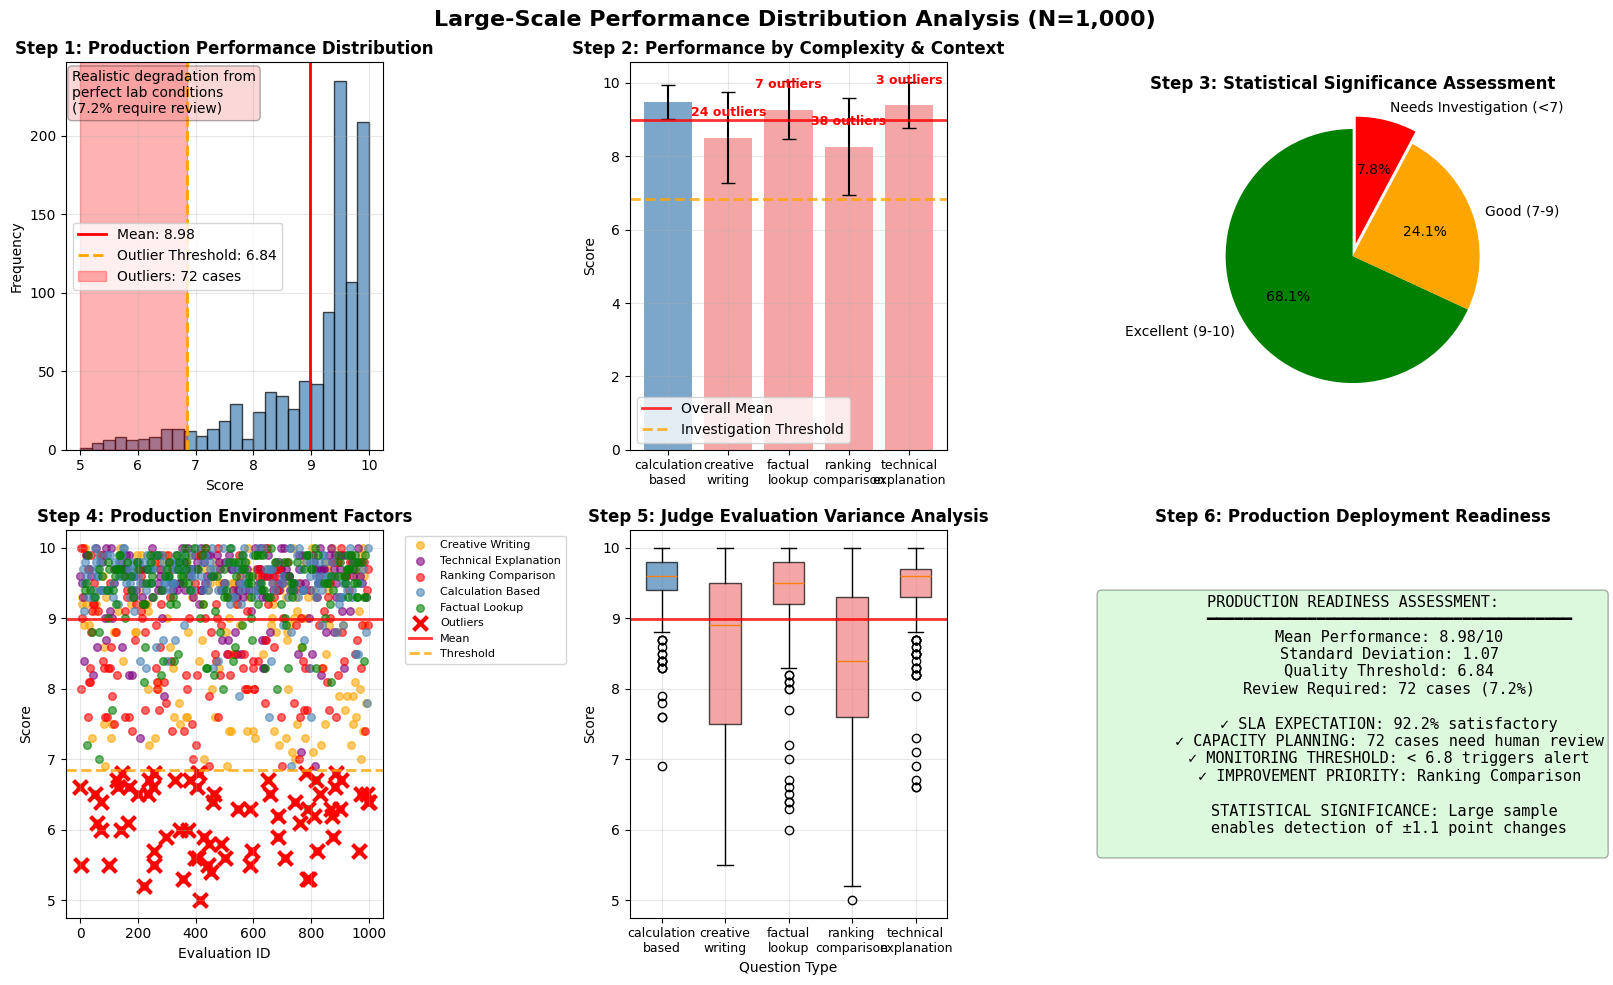

Large-scale analysis complete! Model shows realistic performance distribution
Mean degradation from perfect (10.0) to production reality (8.98)
92.2% of cases meet quality thresholds - ready for production deployment
72 cases (7.2%) require human review - typical for scale
Statistical significance achieved: can detect ±1.1 point performance changes


In [26]:
# Run large-scale analysis
df_scaled, stats, fig = analyze_model_performance(
    n_samples=SCALE_TEST_SAMPLES, 
    random_seed=RANDOM_SEED, 
    show_plots=SHOW_PLOTS
)

---
## What We've Accomplished

1. **Built a comprehensive evaluation framework** combining programmatic and judge-based evaluation
2. **Demonstrated the power of context** through RAG implementation
3. **Scaled our evaluation** to production volumes
4. **Identified performance patterns** across question types



## Key Takeaways

- **Without context**: Models can struggle with factual accuracy (~33% success rate)
- **With context (RAG)**: Performance improves dramatically (>90% success rate)
- **At scale**: Performance remains stable with predictable variance

### Next Steps

1. **Expand question diversity** - Add more complex, multi-step questions
2. **Implement continuous monitoring** - Set up automated evaluation pipelines
3. **Optimize for weak areas** - Focus on improving lowest-performing categories
4. **A/B test improvements** - Compare different prompting strategies

### Final Thought

> "The quality of an AI system is only as good as its evaluation framework. Today, you've built a robust foundation for continuous improvement."

---
